In [8]:
CUDA_LAUNCH_BLOCKING=1

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
import copy
#
import os
import torch
import numpy as np


class Graph:
    """The Graph to model the skeletons extracted by the Alpha-Pose.
    Args:
        - strategy: (string) must be one of the follow candidates
            - uniform: Uniform Labeling,
            - distance: Distance Partitioning,
            - spatial: Spatial Configuration,
        For more information, please refer to the section 'Partition Strategies'
            in our paper (https://arxiv.org/abs/1801.07455).
        - layout: (string) must be one of the follow candidates
            - coco_cut: Is COCO format but cut 4 joints (L-R ears, L-R eyes) out.
        - max_hop: (int) the maximal distance between two connected nodes.
        - dilation: (int) controls the spacing between the kernel points.
    """
    def __init__(self,
                 layout='coco_cut',
                 strategy='uniform',
                 max_hop=1,
                 dilation=1):
        self.max_hop = max_hop
        self.dilation = dilation

        self.get_edge(layout)
        self.hop_dis = get_hop_distance(self.num_node, self.edge, max_hop)
        self.get_adjacency(strategy)

    def get_edge(self, layout):
        if layout == 'coco_cut':
            self.num_node = 14
            self_link = [(i, i) for i in range(self.num_node)]
            neighbor_link = [(6, 4), (4, 2), (2, 13), (13, 1), (5, 3), (3, 1), (12, 10),
                             (10, 8), (8, 2), (11, 9), (9, 7), (7, 1), (13, 0)]
            self.edge = self_link + neighbor_link
            self.center = 13
        else:
            raise ValueError('This layout is not supported!')

    def get_adjacency(self, strategy):
        valid_hop = range(0, self.max_hop + 1, self.dilation)
        adjacency = np.zeros((self.num_node, self.num_node))
        for hop in valid_hop:
            adjacency[self.hop_dis == hop] = 1
        normalize_adjacency = normalize_digraph(adjacency)

        if strategy == 'uniform':
            A = np.zeros((1, self.num_node, self.num_node))
            A[0] = normalize_adjacency
            self.A = A
        elif strategy == 'distance':
            A = np.zeros((len(valid_hop), self.num_node, self.num_node))
            for i, hop in enumerate(valid_hop):
                A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis ==
                                                                hop]
            self.A = A
        elif strategy == 'spatial':
            A = []
            for hop in valid_hop:
                a_root = np.zeros((self.num_node, self.num_node))
                a_close = np.zeros((self.num_node, self.num_node))
                a_further = np.zeros((self.num_node, self.num_node))
                for i in range(self.num_node):
                    for j in range(self.num_node):
                        if self.hop_dis[j, i] == hop:
                            if self.hop_dis[j, self.center] == self.hop_dis[i, self.center]:
                                a_root[j, i] = normalize_adjacency[j, i]
                            elif self.hop_dis[j, self.center] > self.hop_dis[i, self.center]:
                                a_close[j, i] = normalize_adjacency[j, i]
                            else:
                                a_further[j, i] = normalize_adjacency[j, i]
                if hop == 0:
                    A.append(a_root)
                else:
                    A.append(a_root + a_close)
                    A.append(a_further)
            A = np.stack(A)
            self.A = A
            #self.A = np.swapaxes(np.swapaxes(A, 0, 1), 1, 2)
        else:
            raise ValueError("This strategy is not supported!")


def get_hop_distance(num_node, edge, max_hop=1):
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1

    # compute hop steps
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(max_hop + 1)]
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(max_hop, -1, -1):
        hop_dis[arrive_mat[d]] = d
    return hop_dis


def normalize_digraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-1)
    AD = np.dot(A, Dn)
    return AD


def normalize_undigraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-0.5)
    DAD = np.dot(np.dot(Dn, A), Dn)
    return DAD

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GraphConvolution(nn.Module):
    """The basic module for applying a graph convolution.
    Args:
        - in_channel: (int) Number of channels in the input sequence data.
        - out_channels: (int) Number of channels produced by the convolution.
        - kernel_size: (int) Size of the graph convolving kernel.
        - t_kernel_size: (int) Size of the temporal convolving kernel.
        - t_stride: (int, optional) Stride of the temporal convolution. Default: 1
        - t_padding: (int, optional) Temporal zero-padding added to both sides of
            the input. Default: 0
        - t_dilation: (int, optional) Spacing between temporal kernel elements. Default: 1
        - bias: (bool, optional) If `True`, adds a learnable bias to the output.
            Default: `True`
    Shape:
        - Inputs x: Graph sequence in :math:`(N, in_channels, T_{in}, V)`,
                 A: Graph adjacency matrix in :math:`(K, V, V)`,
        - Output: Graph sequence out in :math:`(N, out_channels, T_{out}, V)`

            where
                :math:`N` is a batch size,
                :math:`K` is the spatial kernel size, as :math:`K == kernel_size[1]`,
                :math:`T_{in}/T_{out}` is a length of input/output sequence,
                :math:`V` is the number of graph nodes.

    """
    def __init__(self, in_channels, out_channels, kernel_size,
                 t_kernel_size=1,
                 t_stride=1,
                 t_padding=0,
                 t_dilation=1,
                 bias=True):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv = nn.Conv2d(in_channels,
                              out_channels * kernel_size,
                              kernel_size=(t_kernel_size, 1),
                              padding=(t_padding, 0),
                              stride=(t_stride, 1),
                              dilation=(t_dilation, 1),
                              bias=bias)

    def forward(self, x, A):
        x = self.conv(x)
        n, kc, t, v = x.size()
        x = x.view(n, self.kernel_size, kc//self.kernel_size, t, v)
        x = torch.einsum('nkctv,kvw->nctw', (x, A))

        return x.contiguous()
###########################################################
class Channel_Attention(nn.Module):
    def __init__(self,out_channels):
        super().__init__()
        
        self.atten = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Conv2d(out_channels,int(out_channels/4),1),
            nn.BatchNorm2d(int(out_channels/4)),
            nn.ReLU(),
            nn.Conv2d(int(out_channels/4),out_channels,1),
            nn.Sigmoid(),
        )
    def forward(self,x):
        
        atten = self.atten(x)
        # print(x.shape,atten.shape)
        x = x*atten
        
        return x
    

###########################################################

class st_gcn(nn.Module):
    """Applies a spatial temporal graph convolution over an input graph sequence.
    Args:
        - in_channels: (int) Number of channels in the input sequence data.
        - out_channels: (int) Number of channels produced by the convolution.
        - kernel_size: (tuple) Size of the temporal convolving kernel and
            graph convolving kernel.
        - stride: (int, optional) Stride of the temporal convolution. Default: 1
        - dropout: (int, optional) Dropout rate of the final output. Default: 0
        - residual: (bool, optional) If `True`, applies a residual mechanism.
            Default: `True`
    Shape:
        - Inputs x: Graph sequence in :math: `(N, in_channels, T_{in}, V)`,
                 A: Graph Adjecency matrix in :math: `(K, V, V)`,
        - Output: Graph sequence out in :math: `(N, out_channels, T_{out}, V)`
            where
                :math:`N` is a batch size,
                :math:`K` is the spatial kernel size, as :math:`K == kernel_size[1]`,
                :math:`T_{in}/T_{out}` is a length of input/output sequence,
                :math:`V` is the number of graph nodes.
    """
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1,
                 dropout=0,
                 residual=True):
        super().__init__()
        assert len(kernel_size) == 2
        assert kernel_size[0] % 2 == 1
        #print(kernel_size)(9, 3)
        padding = ((kernel_size[0] - 1) // 2, 0)
        #print(padding)(4, 0)

        self.gcn = GraphConvolution(in_channels, out_channels, kernel_size[1])
        self.tcn = nn.Sequential(nn.BatchNorm2d(out_channels),
                                 nn.ReLU(inplace=False),
                                 nn.Conv2d(out_channels,
                                           out_channels,
                                           (kernel_size[0], 1),
                                           (stride, 1),
                                           padding),
                                 nn.BatchNorm2d(out_channels),
                                 nn.Dropout(dropout, inplace=True),
                                 )

        if not residual:
            self.residual = lambda x: 0
        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x
        else:
            self.residual = nn.Sequential(nn.Conv2d(in_channels,
                                                    out_channels,
                                                    kernel_size=1,
                                                    stride=(stride, 1)),
                                          nn.BatchNorm2d(out_channels)
                                          )
        self.relu = nn.ReLU(inplace=False)
        self.channel_attention_module = Channel_Attention(out_channels) 
        
    def forward(self, x, A):
        res = self.residual(x)
        # print(res)
        x = self.gcn(x, A)
        #print("x_in:",x.size())
        # x = self.tcn(x) + res
        #print("x_out:",x.size())
        x = self.tcn(x)
        x = self.channel_attention_module(x) + res
        
        return self.relu(x)


class StreamSpatialTemporalGraph(nn.Module):
    """Spatial temporal graph convolutional networks.
    Args:
        - in_channels: (int) Number of input channels.
        - graph_args: (dict) Args map of `Actionsrecognition.Utils.Graph` Class.
        - num_class: (int) Number of class outputs. If `None` return pooling features of
            the last st-gcn layer instead.
        - edge_importance_weighting: (bool) If `True`, adds a learnable importance
            weighting to the edges of the graph.
        - **kwargs: (optional) Other parameters for graph convolution units.
    Shape:
        - Input: :math:`(N, in_channels, T_{in}, V_{in})`
        - Output: :math:`(N, num_class)` where
            :math:`N` is a batch size,
            :math:`T_{in}` is a length of input sequence,
            :math:`V_{in}` is the number of graph nodes,
        or If num_class is `None`: `(N, out_channels)`
            :math:`out_channels` is number of out_channels of the last layer.
    """
    def __init__(self, in_channels, graph_args, num_class=None,
                 edge_importance_weighting=True, **kwargs):
        super().__init__()
        # Load graph.
        graph = Graph(**graph_args)
        A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False)
        self.register_buffer('A', A)

        # Networks.
        spatial_kernel_size = A.size(0)
        temporal_kernel_size = 9
        kernel_size = (temporal_kernel_size, spatial_kernel_size)
        kwargs0 = {k: v for k, v in kwargs.items() if k != 'dropout'}

        self.data_bn = nn.BatchNorm1d(in_channels * A.size(1))
        self.st_gcn_networks = nn.ModuleList((
            st_gcn(in_channels, 64, kernel_size, 1, residual=False, **kwargs0),
            
            st_gcn(64, 64, kernel_size, 1, **kwargs),
            st_gcn(64, 64, kernel_size, 1, **kwargs),
            # st_gcn(64, 64, kernel_size, 1, **kwargs),
            st_gcn(64, 128, kernel_size, 2, **kwargs),
            st_gcn(128, 128, kernel_size, 1, **kwargs),
            # st_gcn(128, 128, kernel_size, 1, **kwargs),
            st_gcn(128, 256, kernel_size, 2, **kwargs),
            st_gcn(256, 256, kernel_size, 1, **kwargs),
            # st_gcn(256, 256, kernel_size, 1, **kwargs)
        ))

        # initialize parameters for edge importance weighting.
        if edge_importance_weighting:
            self.edge_importance = nn.ParameterList([
                nn.Parameter(torch.ones(A.size()))
                for i in self.st_gcn_networks
            ])
        else:
            self.edge_importance = [1] * len(self.st_gcn_networks)

        if num_class is not None:
            self.cls = nn.Conv2d(256, num_class, kernel_size=1)
        else:
            self.cls = lambda x: x

    def forward(self, x):
        # data normalization.
        N, C, T, V = x.size()
        x = x.permute(0, 3, 1, 2).contiguous()  # (N, V, C, T)
        x = x.view(N, V * C, T)
        x = self.data_bn(x)
        x = x.view(N, V, C, T)
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(N, C, T, V)

        # forward.
        for gcn, importance in zip(self.st_gcn_networks, self.edge_importance):
            x = gcn(x, self.A * importance)
        #(B: 32,256, 6 or 7, node: 14, )
        x = F.avg_pool2d(x, x.size()[2:])
        x = self.cls(x)
        x = x.view(x.size(0), -1)

        return x


class TwoStreamSpatialTemporalGraph(nn.Module):
    """Two inputs spatial temporal graph convolutional networks.
    Args:
        - graph_args: (dict) Args map of `Actionsrecognition.Utils.Graph` Class.
        - num_class: (int) Number of class outputs.
        - edge_importance_weighting: (bool) If `True`, adds a learnable importance
            weighting to the edges of the graph.
        - **kwargs: (optional) Other parameters for graph convolution units.
    Shape:
        - Input: :tuple of math:`((N, 3, T, V), (N, 2, T, V))`
        for points and motions stream where.
            :math:`N` is a batch size,
            :math:`in_channels` is data channels (3 is (x, y, score)), (2 is (mot_x, mot_y))
            :math:`T` is a length of input sequence,
            :math:`V` is the number of graph nodes,
        - Output: :math:`(N, num_class)`
    """
    def __init__(self, graph_args, num_class, edge_importance_weighting=True,
                 **kwargs):
        super().__init__()
        self.pts_stream = StreamSpatialTemporalGraph(3, graph_args, None,
                                                     edge_importance_weighting,
                                                     **kwargs)#3 is x,y,z
        self.mot_stream = StreamSpatialTemporalGraph(2, graph_args, None,
                                                     edge_importance_weighting,
                                                     **kwargs)#2 is x,y
        self.fcn = nn.Linear((256 * 2)+2, num_class)
        self.sensor = CNN_BiLSTM(hidden_size=16,num_layers=1,dropout_prob=0.3,num_classes=2,feature="mean")
        
        # self.attention1=nn.Sequential(
        #     nn.Linear(256 * 2, 128),
        #     nn.BatchNorm1d(128),
        #     nn.LeakyReLU(inplace=False),
        #     nn.Linear(128, 256 * 2),
        #     nn.BatchNorm1d(256 * 2),
        #     nn.Sigmoid(),
        # )
        
        # self.attention2=nn.Sequential(
        #     nn.Linear(256 * 2, 128),
        #     nn.BatchNorm1d(128),
        #     nn.ReLU(inplace=False),
        #     nn.Linear(128, 256 * 2),
        #     nn.BatchNorm1d(256 * 2),
        #     nn.Sigmoid(),
        # )
        
        # self.attention3=nn.Sequential(
        #     nn.Linear(256 * 2, 64),
        #     nn.BatchNorm1d(64),
        #     nn.ReLU(inplace=False),
        #     nn.Linear(64, 256 * 2),
        #     nn.BatchNorm1d(256 * 2),
        #     nn.Sigmoid(),
        # )
        
        # self.attention4=nn.Sequential(
        #     nn.Linear(256 * 2, 64),
        #     nn.BatchNorm1d(64),
        #     nn.ReLU(inplace=False),
        #     nn.Linear(64, 64),
        #     nn.BatchNorm1d(64),
        #     nn.ReLU(inplace=False),
        #     nn.Linear(64, 256 * 2),
        #     nn.BatchNorm1d(256 * 2),
        #     nn.Sigmoid(),
        # )
        
        # self.attention5=nn.Sequential(
        #     nn.Linear(256 * 2, 128),
        #     nn.BatchNorm1d(128),
        #     nn.GELU(),
        #     nn.Linear(128, 256 * 2),
        #     nn.BatchNorm1d(256 * 2),
        #     nn.Sigmoid(),
        # )
        
    def forward(self, inputs):
        out1 = self.pts_stream(inputs[0])
        out2 = self.mot_stream(inputs[1])
        out3 = self.sensor(inputs[2])
        print(out3.size(),out2.size())
        
        #print(out1.size())torch.Size([32, 256])
        #print(out2.size())torch.Size([32, 256])
        concat = torch.cat([out1, out2, out3], dim=-1)
    
        
        # concat =  self.attention1(concat)
        # concat =  self.attention2(concat)
        # concat =  self.attention3(concat)
        # concat =  self.attention4(concat)
        # concat =  self.attention5(concat)
        
        out = self.fcn(concat)
        #print(out.size())
        # return torch.sigmoid(out)
        return F.softmax(out,dim=-1)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as f

####CNN######
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(4, 16, kernel_size=5, padding=2), #batch,チャンネル、シーケンス 入力チャンネル=30, 出力チャンネル=16
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2))
        self.fc = nn.Linear(32*7, 32)  

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        # x = x.view(x.size(0), -1)  # Flatten
        # print(x.size())
        # x = self.fc(x)
        return x
####LSTM#####
class ChannelAttention(nn.Module):
    def __init__(self, input_size, reduce_rate = 1/8):
        super(ChannelAttention,self).__init__()
        
        self.attention = nn.Sequential(
            nn.Linear(input_size, int(input_size*reduce_rate)),
            nn.ReLU(),
            nn.Linear(int(input_size*reduce_rate), input_size),
            nn.Sigmoid(),
        )
        
    def forward(self,x):
        weight = self.attention(x)
        x = torch.einsum('bc,bc -> bc',(x,weight))
        return x
    
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob, num_classes = 1, feature = "last"):
        super(BiLSTM,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        # Bidirectional LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True,dropout=dropout_prob)
        
        self.batchnorm = nn.BatchNorm1d(hidden_size*2)
        self.channelattention = ChannelAttention(hidden_size*2)
        
        self.feature = feature
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_size*2,num_classes)
        )
        
    def forward(self, x):
        # x = self.attention(x)
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # Multiply by 2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm1(x, (h0, c0))
        
        
        # out = self.meanovertime(out)
        if self.feature=="last":
            out = out[:, -1, :]
        else:
            out = torch.mean(out,axis=1,keepdim=False)
        out = self.batchnorm(out)
        out = self.channelattention(out)
        out = self.fc(out)
        return out
    
class CNN_BiLSTM(nn.Module):
    def __init__(self, hidden_size, num_layers, dropout_prob, num_classes=1, feature="last"):
        super(CNN_BiLSTM, self).__init__()
        self.cnn = CNN1D()
        self.bilstm = BiLSTM(input_size=32,hidden_size=64,num_layers=1,dropout_prob=0.3,num_classes=2,feature="mean")
    
    def forward(self, x):
        x = x.permute(0,2,1)
        cnn_out = self.cnn(x)
        # print(cnn_out)
        cnn_out = cnn_out.permute(0,2,1)
        lstm_out = self.bilstm(cnn_out)
        # cnn_out = cnn_out.unsqueeze(1)  # LSTMに渡すために次元を調整 (batch, seq_len, feature)
        # lstm_out = self.bilstm(cnn_out)
        # print("err2")
        return lstm_out
    
    
# model = BiLSTM(input_size=4,hidden_size=125,num_layers=1,dropout_prob=0.3,num_classes=2,feature="mean")

In [11]:
# inp=torch.randn(8,2,21,14)
# inp=inp.cuda()

# #print(a[1].shape)
# a=model(inp)
# print(a.shape)

In [12]:
import torch
from torch.utils.data import Dataset

class Skeleton_Sensor_Dataset(Dataset):
    def __init__(self,skeleton_sensor_data,label):
        self.skeleton_sensor_data = skeleton_sensor_data
        self.label = label
        
    def __len__(self):
        return len(self.skeleton_sensor_data)
    
    def __getitem__(self,idx):
        skeleton,sensor = self.skeleton_sensor_data[idx]
        label = self.label[idx]
        
        # print(f"DEBUG {type(skeleton.dtype)}, {type(sensor.dtype)} {type(label.dtype)} ")
        
        if not isinstance(skeleton,torch.Tensor):
            skeleton = torch.tensor(skeleton,dtype=torch.float32)
            
        if not isinstance(sensor,torch.Tensor):
            sensor = torch.tensor(sensor,dtype=torch.float32)
        
        if not isinstance(label,torch.Tensor):
            label = torch.tensor(label,dtype=torch.float32)
            
        skeleton = skeleton.permute(2,0,1)
        return skeleton,sensor,label
    
class Skeleton_Sensor_Dataset_v2(Dataset):
    def __init__(self,skeleton_sensor_data,label):
        self.skeleton_sensor_data = skeleton_sensor_data
        self.label = label
        
    def __len__(self):
        return len(self.skeleton_sensor_data)
    
    def __getitem__(self,idx):
        skeleton,sensor = self.skeleton_sensor_data[idx]
        label = self.label[idx]
        
        # print(f"DEBUG {type(skeleton.dtype)}, {type(sensor.dtype)} {type(label.dtype)} ")
        
        if not isinstance(skeleton,torch.Tensor):
            skeleton = torch.tensor(skeleton,dtype=torch.float32)
            
        if not isinstance(sensor,torch.Tensor):
            sensor = torch.tensor(sensor,dtype=torch.float32)
        
        if not isinstance(label,torch.Tensor):
            label = torch.tensor(label,dtype=torch.float32)
            
        skeleton = skeleton.permute(2,0,1) # skeleton [num_sample, (time, vertex, xyz)] -> [num_sample, (xyz, time, vertex)]
        return skeleton,sensor,label
    
def custom_collate_fn(batch):
    skeletons = [item[0] for item in batch]
    sensors = [item[1] for item in batch]
    labels = [item[2] for item in batch]

    skeletons = torch.stack(skeletons)
    sensors = torch.stack(sensors)
    labels = torch.stack(labels)  # 例: ラベルが整数である場合

    return skeletons, sensors, labels

In [13]:
def load_dataset(data_files, batch_size, split_size=0.2):#0.2
    """Load data files into torch DataLoader with/without spliting train-test.
    """
    features,sensors, labels = [], [], []
    for fil in data_files:
        # print(fil)
        with open(fil, 'rb') as f:
            _ ,fts,sr,lbs = pickle.load(f)
            videos += vid
            features.append(fts)
            sensors.append(sr)
            labels.append(lbs)
        del fts, lbs,sr
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    sensors = np.concatenate(sensors, axis=0)
    # print(features.shape,labels.shape)
    # print(f"DEBUG {features.shape},{sensors.shape},{labels.shape}")
    labels = labels.astype(np.float32)
    
    samples = []
    for feature,sensor in zip(features,sensors):
        samples += [(feature,sensor)]
    # samples = np.array(samples,dtype=object)
    
    if split_size > 0:
        x_train, x_valid, y_train, y_valid = train_test_split(samples, labels, test_size=split_size,random_state=9)
        
        # train_set = data.TensorDataset(torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2),
        #                                torch.tensor(y_train, dtype=torch.float32))
        # valid_set = data.TensorDataset(torch.tensor(x_valid, dtype=torch.float32).permute(0, 3, 1, 2),
        #                                torch.tensor(y_valid, dtype=torch.float32))
        train_set = Skeleton_Sensor_Dataset(x_train,y_train)
        valid_set = Skeleton_Sensor_Dataset(x_valid,y_valid)
        train_loader = data.DataLoader(train_set, batch_size, shuffle=True)
        valid_loader = data.DataLoader(valid_set, batch_size)
    else:
        # train_set = data.TensorDataset(torch.tensor(features, dtype=torch.float32).permute(0, 3, 1, 2),
        #                                torch.tensor(labels, dtype=torch.float32))
        train_set = Skeleton_Sensor_Dataset(features,labels)
        train_loader = data.DataLoader(train_set, batch_size, shuffle=True)
        valid_loader = None
    return train_loader, valid_loader


def load_dataset_v2(data_files, batch_size, split_size=0.2):#0.2
    """Load data files into torch DataLoader with/without spliting train-test.
    """
    videos = []
    features,sensors, labels = [], [], []
    for fil in data_files:
        # print(fil)
        with open(fil, 'rb') as f:
            vid ,fts,sr, lbs = pickle.load(f)
            videos += vid
            features.append(fts)
            sensors.append(sr)
            labels.append(lbs)
        del fts, lbs,sr
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    sensors = np.concatenate(sensors, axis=0)
    # print(features.shape,labels.shape)
    # print(f"DEBUG {features.shape},{sensors.shape},{labels.shape}")
    labels = labels.astype(np.float32) # dtype : object -> float32
    
    if split_size > 0:
        unique_video_names = np.unique(videos)
        train_videos, test_videos= train_test_split(unique_video_names,test_size=split_size,random_state=9)

        train_samples,valid_samples = [],[]
        train_label,valid_label = [],[]
        for video,feature,sensor,label in zip(videos,features,sensors,labels):
            if video in train_videos:
                train_samples += [(feature,sensor)]
                train_label += [label]
            else:
                valid_samples += [(feature,sensor)]
                valid_label += [label]
        
        train_set = Skeleton_Sensor_Dataset(train_samples,train_label)
        valid_set = Skeleton_Sensor_Dataset(valid_samples,valid_label)
        train_loader = data.DataLoader(train_set, batch_size, shuffle=True,)
        valid_loader = data.DataLoader(valid_set, batch_size)
    
    else:
        samples = []
        for feature,sensor in zip(features,sensors):
            samples += [(feature,sensor)]
        train_set = Skeleton_Sensor_Dataset(samples,labels)
        train_loader = data.DataLoader(train_set, batch_size, shuffle=True)
        valid_loader = None
    return train_loader, valid_loader

using cuda device
number of params: 4311324
Epoch 0/99


train:   7%|▋         | 2/30 [00:00<00:01, 17.37it/s,  loss: 0.3339, accu: 0.9375]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  13%|█▎        | 4/30 [00:00<00:01, 17.37it/s,  loss: 0.3246, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  37%|███▋      | 11/30 [00:00<00:00, 36.56it/s,  loss: 0.3571, accu: 0.9375]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  40%|████      | 12/30 [00:00<00:00, 36.56it/s,  loss: 0.3460, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  50%|█████     | 15/30 [00:00<00:00, 27.33it/s,  loss: 0.3487, accu: 0.9375]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  70%|███████   | 21/30 [00:00<00:00, 36.35it/s,  loss: 0.3401, accu: 0.9375]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  73%|███████▎  | 22/30 [00:00<00:00, 36.35it/s,  loss: 0.3343, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 36.35it/s,  loss: 0.3284, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:00, 35.19it/s,  loss: 0.3272, accu: 0.9688]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 33it [00:01, 35.19it/s,  loss: 0.3422, accu: 0.8750]

torch.Size([32, 2]) torch.Size([32, 256])


train: 37it [00:01, 28.46it/s,  loss: 0.3233, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 37it [00:01, 28.46it/s,  loss: 0.3213, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train: 41it [00:01, 25.60it/s,  loss: 0.3209, accu: 0.9375]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid:   0%|          | 0/8 [00:00<?, ?it/s,  loss: 0.3059, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.77it/s,  loss: 0.3741, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3401, accu: 0.9323
 - Valid loss: 0.3808, accu: 0.9180
0.91796875
Epoch 1/99


train:  20%|██        | 6/30 [00:00<00:01, 20.07it/s,  loss: 0.3132, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  47%|████▋     | 14/30 [00:00<00:00, 44.82it/s,  loss: 0.3303, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  50%|█████     | 15/30 [00:00<00:00, 44.82it/s,  loss: 0.3380, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  63%|██████▎   | 19/30 [00:00<00:00, 30.03it/s,  loss: 0.3268, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  67%|██████▋   | 20/30 [00:00<00:00, 30.03it/s,  loss: 0.3456, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  77%|███████▋  | 23/30 [00:00<00:00, 25.96it/s,  loss: 0.3266, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  97%|█████████▋| 29/30 [00:00<00:00, 33.50it/s,  loss: 0.3157, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 31it [00:01, 33.50it/s,  loss: 0.3311, accu: 0.9688]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 34it [00:01, 27.46it/s,  loss: 0.3321, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 35it [00:01, 27.46it/s,  loss: 0.3271, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 38it [00:01, 24.90it/s,  loss: 0.3294, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 20.04it/s,  loss: 0.3429, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid:   0%|          | 0/8 [00:00<?, ?it/s,  loss: 0.3046, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


valid:  38%|███▊      | 3/8 [00:00<00:00, 49.68it/s,  loss: 0.4579, accu: 0.8125]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.99it/s,  loss: 0.3740, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3262, accu: 0.9844
 - Valid loss: 0.3784, accu: 0.9180
0.91796875
Epoch 2/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.97it/s,  loss: 0.3573, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.41it/s,  loss: 0.3197, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  60%|██████    | 18/30 [00:00<00:00, 29.22it/s,  loss: 0.3342, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  87%|████████▋ | 26/30 [00:00<00:00, 30.98it/s,  loss: 0.3060, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 31it [00:01, 26.62it/s,  loss: 0.3380, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.47it/s,  loss: 0.3333, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 20.05it/s,  loss: 0.3477, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.45it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])


Summary epoch:
 - Train loss: 0.3280, accu: 0.9792
 - Valid loss: 0.3566, accu: 0.9727
0.97265625
Epoch 3/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.92it/s,  loss: 0.3153, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.44it/s,  loss: 0.3132, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  60%|██████    | 18/30 [00:00<00:00, 29.27it/s,  loss: 0.3132, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  87%|████████▋ | 26/30 [00:00<00:00, 30.99it/s,  loss: 0.2999, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 31it [00:01, 26.64it/s,  loss: 0.3402, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.54it/s,  loss: 0.3325, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 20.07it/s,  loss: 0.3326, accu: 1.0000]


torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.40it/s,  loss: 0.3739, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3246, accu: 0.9917
 - Valid loss: 0.3551, accu: 0.9727
0.97265625
Epoch 4/99


train:  13%|█▎        | 4/30 [00:00<00:01, 20.00it/s,  loss: 0.3262, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  20%|██        | 6/30 [00:00<00:00, 31.68it/s,  loss: 0.3174, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.39it/s,  loss: 0.3298, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  47%|████▋     | 14/30 [00:00<00:00, 44.39it/s,  loss: 0.3372, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.23it/s,  loss: 0.3198, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  60%|██████    | 18/30 [00:00<00:00, 29.23it/s,  loss: 0.3244, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.31it/s,  loss: 0.3327, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  87%|████████▋ | 26/30 [00:00<00:00, 30.88it/s,  loss: 0.3247, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.88it/s,  loss: 0.3266, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 26.54it/s,  loss: 0.3043, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.54it/s,  loss: 0.3206, accu: 0.9688]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 34it [00:01, 24.14it/s,  loss: 0.3327, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.41it/s,  loss: 0.3310, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 41it [00:01, 31.41it/s,  loss: 0.3244, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.14it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3245, accu: 0.9927
 - Valid loss: 0.3546, accu: 0.9727
0.97265625


Epoch 5/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.98it/s,  loss: 0.3005, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  20%|██        | 6/30 [00:00<00:00, 31.70it/s,  loss: 0.3475, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.36it/s,  loss: 0.3305, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  47%|████▋     | 14/30 [00:00<00:00, 44.36it/s,  loss: 0.3090, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.21it/s,  loss: 0.3341, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  60%|██████    | 18/30 [00:00<00:00, 29.21it/s,  loss: 0.3222, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.35it/s,  loss: 0.3154, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 26.59it/s,  loss: 0.3190, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 38it [00:01, 24.19it/s,  loss: 0.3080, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 20.06it/s,  loss: 0.3445, accu: 0.9545]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid:  38%|███▊      | 3/8 [00:00<00:00, 50.01it/s,  loss: 0.4284, accu: 0.9375]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.17it/s,  loss: 0.3739, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3246, accu: 0.9933
 - Valid loss: 0.3544, accu: 0.9805
0.98046875
Epoch 6/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.93it/s,  loss: 0.3380, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.39it/s,  loss: 0.3226, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  60%|██████    | 18/30 [00:00<00:00, 29.25it/s,  loss: 0.3327, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  87%|████████▋ | 26/30 [00:00<00:00, 30.94it/s,  loss: 0.3349, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 26.58it/s,  loss: 0.3414, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.47it/s,  loss: 0.3177, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 20.04it/s,  loss: 0.3083, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.96it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3242, accu: 0.9938
 - Valid loss: 0.3545, accu: 0.9766
0.98046875


Epoch 7/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.99it/s,  loss: 0.3290, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  20%|██        | 6/30 [00:00<00:00, 31.72it/s,  loss: 0.3244, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.42it/s,  loss: 0.3169, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  47%|████▋     | 14/30 [00:00<00:00, 44.42it/s,  loss: 0.3201, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  60%|██████    | 18/30 [00:00<00:00, 29.22it/s,  loss: 0.3197, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  63%|██████▎   | 19/30 [00:00<00:00, 29.22it/s,  loss: 0.3206, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  87%|████████▋ | 26/30 [00:00<00:00, 30.88it/s,  loss: 0.3208, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  87%|████████▋ | 26/30 [00:00<00:00, 30.88it/s,  loss: 0.3151, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 26.52it/s,  loss: 0.3171, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 26.52it/s,  loss: 0.3005, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train: 34it [00:01, 24.14it/s,  loss: 0.3405, accu: 0.9688]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 38it [00:01, 24.14it/s,  loss: 0.3214, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 20.01it/s,  loss: 0.3338, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid:   0%|          | 0/8 [00:00<?, ?it/s,  loss: 0.3049, accu: 0.9375]

torch.Size([32, 2]) torch.Size([32, 256])


valid:  38%|███▊      | 3/8 [00:00<00:00, 49.62it/s,  loss: 0.4285, accu: 0.9375]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.88it/s,  loss: 0.3739, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3244, accu: 0.9927
 - Valid loss: 0.3541, accu: 0.9844
0.984375
Epoch 8/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.93it/s,  loss: 0.3331, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.40it/s,  loss: 0.3308, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  60%|██████    | 18/30 [00:00<00:00, 29.22it/s,  loss: 0.3031, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  87%|████████▋ | 26/30 [00:00<00:00, 30.91it/s,  loss: 0.3121, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 26.57it/s,  loss: 0.3076, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 38it [00:01, 24.17it/s,  loss: 0.3350, accu: 0.9688]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 20.03it/s,  loss: 0.3216, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid:  38%|███▊      | 3/8 [00:00<00:00, 49.90it/s,  loss: 0.4321, accu: 0.8750]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.22it/s,  loss: 0.3739, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3244, accu: 0.9917
 - Valid loss: 0.3547, accu: 0.9766
0.984375
Epoch 9/99


train:  10%|█         | 3/30 [00:00<00:01, 20.02it/s,  loss: 0.3362, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  20%|██        | 6/30 [00:00<00:01, 20.02it/s,  loss: 0.3235, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  47%|████▋     | 14/30 [00:00<00:00, 44.79it/s,  loss: 0.3359, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  50%|█████     | 15/30 [00:00<00:00, 44.79it/s,  loss: 0.3343, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  63%|██████▎   | 19/30 [00:00<00:00, 29.98it/s,  loss: 0.3203, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  67%|██████▋   | 20/30 [00:00<00:00, 29.98it/s,  loss: 0.3330, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  77%|███████▋  | 23/30 [00:00<00:00, 25.88it/s,  loss: 0.3205, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  97%|█████████▋| 29/30 [00:00<00:00, 33.42it/s,  loss: 0.3105, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 33.42it/s,  loss: 0.3187, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 33.42it/s,  loss: 0.3119, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 34it [00:01, 27.39it/s,  loss: 0.3308, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train: 38it [00:01, 24.86it/s,  loss: 0.3102, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 38it [00:01, 24.86it/s,  loss: 0.3260, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 20.00it/s,  loss: 0.3406, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid:  38%|███▊      | 3/8 [00:00<00:00, 50.01it/s,  loss: 0.4281, accu: 0.9375]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.30it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3244, accu: 0.9938
 - Valid loss: 0.3543, accu: 0.9805
0.984375


Epoch 10/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.99it/s,  loss: 0.3134, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  20%|██        | 6/30 [00:00<00:00, 31.63it/s,  loss: 0.3320, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.39it/s,  loss: 0.3253, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  47%|████▋     | 14/30 [00:00<00:00, 44.39it/s,  loss: 0.3316, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.23it/s,  loss: 0.3290, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  60%|██████    | 18/30 [00:00<00:00, 29.23it/s,  loss: 0.3143, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  87%|████████▋ | 26/30 [00:00<00:00, 30.91it/s,  loss: 0.3283, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  87%|████████▋ | 26/30 [00:00<00:00, 30.91it/s,  loss: 0.3151, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 26.54it/s,  loss: 0.3292, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 26.54it/s,  loss: 0.3282, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train: 34it [00:01, 24.13it/s,  loss: 0.3212, accu: 0.9688]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 38it [00:01, 24.13it/s,  loss: 0.3189, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train: 41it [00:01, 31.37it/s,  loss: 0.3309, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid:   0%|          | 0/8 [00:00<?, ?it/s,  loss: 0.3102, accu: 0.8750]

torch.Size([32, 2]) torch.Size([32, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.34it/s,  loss: 0.3739, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3242, accu: 0.9958
 - Valid loss: 0.3542, accu: 0.9727
0.984375
Epoch 11/99


train:  10%|█         | 3/30 [00:00<00:01, 20.02it/s,  loss: 0.3025, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  20%|██        | 6/30 [00:00<00:01, 20.02it/s,  loss: 0.3301, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  47%|████▋     | 14/30 [00:00<00:00, 44.88it/s,  loss: 0.3035, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  50%|█████     | 15/30 [00:00<00:00, 44.88it/s,  loss: 0.3103, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  63%|██████▎   | 19/30 [00:00<00:00, 30.00it/s,  loss: 0.3272, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  63%|██████▎   | 19/30 [00:00<00:00, 30.00it/s,  loss: 0.3192, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  77%|███████▋  | 23/30 [00:00<00:00, 25.91it/s,  loss: 0.3298, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 31it [00:01, 33.45it/s,  loss: 0.3123, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 36it [00:01, 27.46it/s,  loss: 0.3285, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 20.05it/s,  loss: 0.3183, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid:  38%|███▊      | 3/8 [00:00<00:00, 50.04it/s,  loss: 0.4262, accu: 0.9375]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.36it/s,  loss: 0.3739, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3241, accu: 0.9917
 - Valid loss: 0.3538, accu: 0.9844
0.984375
Epoch 12/99


train:  10%|█         | 3/30 [00:00<00:01, 20.00it/s,  loss: 0.3168, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  20%|██        | 6/30 [00:00<00:01, 20.00it/s,  loss: 0.3194, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  47%|████▋     | 14/30 [00:00<00:00, 44.74it/s,  loss: 0.3309, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  50%|█████     | 15/30 [00:00<00:00, 44.74it/s,  loss: 0.3144, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  63%|██████▎   | 19/30 [00:00<00:00, 29.95it/s,  loss: 0.3181, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  63%|██████▎   | 19/30 [00:00<00:00, 29.95it/s,  loss: 0.3174, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  77%|███████▋  | 23/30 [00:00<00:00, 25.87it/s,  loss: 0.3320, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  77%|███████▋  | 23/30 [00:00<00:00, 25.87it/s,  loss: 0.3267, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 33.39it/s,  loss: 0.3232, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 31it [00:01, 33.39it/s,  loss: 0.3259, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 34it [00:01, 27.40it/s,  loss: 0.3224, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 36it [00:01, 27.40it/s,  loss: 0.3297, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 38it [00:01, 24.89it/s,  loss: 0.3288, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 20.00it/s,  loss: 0.3425, accu: 1.0000]


torch.Size([22, 2]) torch.Size([22, 256])


valid:  38%|███▊      | 3/8 [00:00<00:00, 50.13it/s,  loss: 0.4296, accu: 0.8750]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.15it/s,  loss: 0.3739, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3243, accu: 0.9948
 - Valid loss: 0.3547, accu: 0.9766
0.984375
Epoch 13/99


train:  10%|█         | 3/30 [00:00<00:01, 20.08it/s,  loss: 0.3285, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  20%|██        | 6/30 [00:00<00:01, 20.08it/s,  loss: 0.3183, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  47%|████▋     | 14/30 [00:00<00:00, 44.85it/s,  loss: 0.3092, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  50%|█████     | 15/30 [00:00<00:00, 44.85it/s,  loss: 0.3250, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train:  63%|██████▎   | 19/30 [00:00<00:00, 30.02it/s,  loss: 0.3215, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  63%|██████▎   | 19/30 [00:00<00:00, 30.02it/s,  loss: 0.3171, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  77%|███████▋  | 23/30 [00:00<00:00, 25.90it/s,  loss: 0.3135, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  97%|█████████▋| 29/30 [00:00<00:00, 33.41it/s,  loss: 0.3234, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 33.41it/s,  loss: 0.3298, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 33.41it/s,  loss: 0.3185, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 34it [00:01, 27.40it/s,  loss: 0.3222, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train: 38it [00:01, 24.87it/s,  loss: 0.3194, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 38it [00:01, 24.87it/s,  loss: 0.3367, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 20.01it/s,  loss: 0.3351, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid:  38%|███▊      | 3/8 [00:00<00:00, 49.97it/s,  loss: 0.4437, accu: 0.8125]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.13it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3246, accu: 0.9885
 - Valid loss: 0.3587, accu: 0.9648
0.984375


Epoch 14/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.94it/s,  loss: 0.3158, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.28it/s,  loss: 0.3094, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.16it/s,  loss: 0.3302, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.31it/s,  loss: 0.3238, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.83it/s,  loss: 0.3358, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.51it/s,  loss: 0.3224, accu: 0.9688]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.43it/s,  loss: 0.3230, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 20.01it/s,  loss: 0.3272, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.11it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3243, accu: 0.9938
 - Valid loss: 0.3541, accu: 0.9844
0.984375


Epoch 15/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.87it/s,  loss: 0.3081, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.25it/s,  loss: 0.3252, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.15it/s,  loss: 0.3397, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.27it/s,  loss: 0.3388, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.79it/s,  loss: 0.3274, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.44it/s,  loss: 0.3352, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 41it [00:01, 31.37it/s,  loss: 0.3303, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.24it/s,  loss: 0.3739, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3242, accu: 0.9938
 - Valid loss: 0.3544, accu: 0.9766
0.984375
Epoch 16/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.93it/s,  loss: 0.3250, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.22it/s,  loss: 0.3181, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.11it/s,  loss: 0.3255, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.25it/s,  loss: 0.3444, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.79it/s,  loss: 0.3290, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.49it/s,  loss: 0.3284, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.38it/s,  loss: 0.3260, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.98it/s,  loss: 0.3282, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.09it/s,  loss: 0.3740, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3242, accu: 0.9938
 - Valid loss: 0.3544, accu: 0.9727
0.984375


Epoch 17/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.92it/s,  loss: 0.3213, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.22it/s,  loss: 0.3297, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.15it/s,  loss: 0.3102, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.29it/s,  loss: 0.3226, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.81it/s,  loss: 0.3245, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.48it/s,  loss: 0.3134, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.35it/s,  loss: 0.3180, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.97it/s,  loss: 0.3333, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.96it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3242, accu: 0.9948
 - Valid loss: 0.3535, accu: 0.9844
0.984375


Epoch 18/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.94it/s,  loss: 0.3254, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.25it/s,  loss: 0.3322, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.16it/s,  loss: 0.3200, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.28it/s,  loss: 0.3243, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.81it/s,  loss: 0.3313, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.49it/s,  loss: 0.3255, accu: 0.9688]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.38it/s,  loss: 0.3125, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.98it/s,  loss: 0.3241, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.06it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3241, accu: 0.9938
 - Valid loss: 0.3537, accu: 0.9727
0.984375


Epoch 19/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.82it/s,  loss: 0.3317, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.26it/s,  loss: 0.3242, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.19it/s,  loss: 0.3416, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.29it/s,  loss: 0.3374, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.84it/s,  loss: 0.3151, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.51it/s,  loss: 0.3325, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.39it/s,  loss: 0.3155, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.99it/s,  loss: 0.2978, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.28it/s,  loss: 0.3740, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3239, accu: 0.9927
 - Valid loss: 0.3539, accu: 0.9727
0.984375


Epoch 20/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.89it/s,  loss: 0.3241, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.26it/s,  loss: 0.3164, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.15it/s,  loss: 0.3295, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.30it/s,  loss: 0.3354, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.82it/s,  loss: 0.3163, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.50it/s,  loss: 0.3115, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.39it/s,  loss: 0.3290, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.99it/s,  loss: 0.3059, accu: 0.9545]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.08it/s,  loss: 0.3740, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3241, accu: 0.9912
 - Valid loss: 0.3534, accu: 0.9844
0.984375


Epoch 21/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.92it/s,  loss: 0.3055, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.32it/s,  loss: 0.3269, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.16it/s,  loss: 0.3268, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.29it/s,  loss: 0.3203, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.83it/s,  loss: 0.3233, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.50it/s,  loss: 0.3251, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.36it/s,  loss: 0.3304, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.98it/s,  loss: 0.3207, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.03it/s,  loss: 0.3740, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3241, accu: 0.9927
 - Valid loss: 0.3536, accu: 0.9766
0.984375


Epoch 22/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.96it/s,  loss: 0.3224, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.33it/s,  loss: 0.3305, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.17it/s,  loss: 0.3200, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.29it/s,  loss: 0.3437, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.82it/s,  loss: 0.3199, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.51it/s,  loss: 0.3163, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.37it/s,  loss: 0.3142, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.97it/s,  loss: 0.3232, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.68it/s,  loss: 0.3740, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3240, accu: 0.9969
 - Valid loss: 0.3533, accu: 0.9844
0.984375


Epoch 23/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.77it/s,  loss: 0.3293, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.01it/s,  loss: 0.3251, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.95it/s,  loss: 0.3218, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.13it/s,  loss: 0.3352, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.65it/s,  loss: 0.3061, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.32it/s,  loss: 0.3235, accu: 0.9688]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.12it/s,  loss: 0.3391, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.84it/s,  loss: 0.3369, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.89it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3242, accu: 0.9917
 - Valid loss: 0.3544, accu: 0.9805
0.984375


Epoch 24/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.79it/s,  loss: 0.3366, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.96it/s,  loss: 0.3426, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.95it/s,  loss: 0.3268, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.12it/s,  loss: 0.3228, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.61it/s,  loss: 0.3179, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.31it/s,  loss: 0.3273, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.16it/s,  loss: 0.3337, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.85it/s,  loss: 0.3312, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.04it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])


Summary epoch:
 - Train loss: 0.3241, accu: 0.9958
 - Valid loss: 0.3534, accu: 0.9883
0.98828125
Epoch 25/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.73it/s,  loss: 0.3129, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.04it/s,  loss: 0.3148, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.98it/s,  loss: 0.3354, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.15it/s,  loss: 0.3304, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.62it/s,  loss: 0.3187, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.33it/s,  loss: 0.3344, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.17it/s,  loss: 0.3162, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.85it/s,  loss: 0.3273, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.92it/s,  loss: 0.3740, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3240, accu: 0.9958
 - Valid loss: 0.3535, accu: 0.9766
0.98828125


Epoch 26/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.78it/s,  loss: 0.3284, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.04it/s,  loss: 0.3309, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.98it/s,  loss: 0.3129, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.15it/s,  loss: 0.3167, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.64it/s,  loss: 0.3232, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.33it/s,  loss: 0.3259, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.17it/s,  loss: 0.3011, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.86it/s,  loss: 0.3367, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.77it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3242, accu: 0.9969
 - Valid loss: 0.3533, accu: 0.9766
0.98828125


Epoch 27/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.79it/s,  loss: 0.3322, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.95it/s,  loss: 0.3277, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.98it/s,  loss: 0.3437, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.13it/s,  loss: 0.2945, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.62it/s,  loss: 0.3318, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.32it/s,  loss: 0.3216, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.16it/s,  loss: 0.3173, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.86it/s,  loss: 0.3145, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.54it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3239, accu: 0.9938
 - Valid loss: 0.3536, accu: 0.9844
0.98828125


Epoch 28/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.75it/s,  loss: 0.3284, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.97it/s,  loss: 0.3069, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.96it/s,  loss: 0.3297, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.10it/s,  loss: 0.3089, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.62it/s,  loss: 0.3243, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.30it/s,  loss: 0.3148, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.14it/s,  loss: 0.3336, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.84it/s,  loss: 0.3203, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.72it/s,  loss: 0.3741, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3242, accu: 0.9948
 - Valid loss: 0.3554, accu: 0.9844
0.98828125


Epoch 29/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.64it/s,  loss: 0.3207, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.89it/s,  loss: 0.3153, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.92it/s,  loss: 0.3245, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.07it/s,  loss: 0.3218, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.58it/s,  loss: 0.3233, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.29it/s,  loss: 0.3187, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.07it/s,  loss: 0.3205, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.81it/s,  loss: 0.3347, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.63it/s,  loss: 0.3740, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3244, accu: 0.9927
 - Valid loss: 0.3534, accu: 0.9883
0.98828125


Epoch 30/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.79it/s,  loss: 0.3242, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.97it/s,  loss: 0.3278, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.97it/s,  loss: 0.3081, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.13it/s,  loss: 0.3229, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.63it/s,  loss: 0.3102, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.32it/s,  loss: 0.3203, accu: 0.9688]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.15it/s,  loss: 0.3345, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.86it/s,  loss: 0.3163, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.80it/s,  loss: 0.3740, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3239, accu: 0.9958
 - Valid loss: 0.3535, accu: 0.9805
0.98828125


Epoch 31/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.84it/s,  loss: 0.3442, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.10it/s,  loss: 0.3325, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.05it/s,  loss: 0.3306, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.23it/s,  loss: 0.3347, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.72it/s,  loss: 0.3131, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.39it/s,  loss: 0.3167, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.24it/s,  loss: 0.3324, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.90it/s,  loss: 0.3247, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.39it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3240, accu: 0.9948
 - Valid loss: 0.3535, accu: 0.9805
0.98828125


Epoch 32/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.84it/s,  loss: 0.3210, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.97it/s,  loss: 0.3334, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.02it/s,  loss: 0.3300, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.18it/s,  loss: 0.3099, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.69it/s,  loss: 0.3228, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.37it/s,  loss: 0.3217, accu: 0.9688]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.22it/s,  loss: 0.3350, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.89it/s,  loss: 0.3174, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.71it/s,  loss: 0.3740, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3239, accu: 0.9969
 - Valid loss: 0.3532, accu: 0.9844
0.98828125


Epoch 33/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.84it/s,  loss: 0.3141, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.06it/s,  loss: 0.3170, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.04it/s,  loss: 0.3294, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.20it/s,  loss: 0.3065, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.73it/s,  loss: 0.3291, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.38it/s,  loss: 0.3137, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.22it/s,  loss: 0.3301, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.89it/s,  loss: 0.3182, accu: 0.9545]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.90it/s,  loss: 0.3741, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3240, accu: 0.9954
 - Valid loss: 0.3550, accu: 0.9766
0.98828125


Epoch 34/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.75it/s,  loss: 0.3133, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.03it/s,  loss: 0.3214, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.97it/s,  loss: 0.3226, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.13it/s,  loss: 0.3284, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.62it/s,  loss: 0.3239, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.33it/s,  loss: 0.3125, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.18it/s,  loss: 0.3185, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.86it/s,  loss: 0.3464, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.94it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3242, accu: 0.9969
 - Valid loss: 0.3535, accu: 0.9883
0.98828125


Epoch 35/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.74it/s,  loss: 0.3419, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.08it/s,  loss: 0.3337, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.03it/s,  loss: 0.3411, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.19it/s,  loss: 0.3200, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.70it/s,  loss: 0.3182, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.39it/s,  loss: 0.3235, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.23it/s,  loss: 0.3313, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.89it/s,  loss: 0.3466, accu: 0.9545]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.78it/s,  loss: 0.3745, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3244, accu: 0.9922
 - Valid loss: 0.4259, accu: 0.8477
0.98828125


Epoch 36/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.80it/s,  loss: 0.3242, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.03it/s,  loss: 0.3205, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.00it/s,  loss: 0.3423, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.18it/s,  loss: 0.3381, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.69it/s,  loss: 0.3403, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.37it/s,  loss: 0.3177, accu: 0.9688]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.20it/s,  loss: 0.3351, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.89it/s,  loss: 0.3162, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.73it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3247, accu: 0.9896
 - Valid loss: 0.3538, accu: 0.9766
0.98828125


Epoch 37/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.82it/s,  loss: 0.3359, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.05it/s,  loss: 0.3301, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.97it/s,  loss: 0.3365, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.14it/s,  loss: 0.3258, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.65it/s,  loss: 0.3251, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.32it/s,  loss: 0.3153, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.19it/s,  loss: 0.3382, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.87it/s,  loss: 0.3056, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.96it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3240, accu: 0.9958
 - Valid loss: 0.3534, accu: 0.9844
0.98828125


Epoch 38/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.81it/s,  loss: 0.3393, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.11it/s,  loss: 0.3181, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.03it/s,  loss: 0.3241, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.17it/s,  loss: 0.3244, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.68it/s,  loss: 0.3227, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.39it/s,  loss: 0.3309, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.23it/s,  loss: 0.3272, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.90it/s,  loss: 0.3244, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.07it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3240, accu: 0.9958
 - Valid loss: 0.3532, accu: 0.9844
0.98828125


Epoch 39/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.81it/s,  loss: 0.3206, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.10it/s,  loss: 0.3509, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.02it/s,  loss: 0.3185, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.15it/s,  loss: 0.3253, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.66it/s,  loss: 0.3191, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.34it/s,  loss: 0.3423, accu: 0.9688]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.07it/s,  loss: 0.3276, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.82it/s,  loss: 0.3148, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 67.27it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3239, accu: 0.9958
 - Valid loss: 0.3534, accu: 0.9883
0.98828125


Epoch 40/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.54it/s,  loss: 0.3287, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.49it/s,  loss: 0.3419, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.78it/s,  loss: 0.3337, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.00it/s,  loss: 0.3195, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.51it/s,  loss: 0.2979, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.24it/s,  loss: 0.3338, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.06it/s,  loss: 0.3246, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.76it/s,  loss: 0.3139, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 14it [00:00, 64.28it/s,  loss: 0.3739, accu: 1.0000]                      

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 66.46it/s,  loss: 0.3739, accu: 1.0000]


Summary epoch:
 - Train loss: 0.3239, accu: 0.9958
 - Valid loss: 0.3532, accu: 0.9922
0.9921875
Epoch 41/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.74it/s,  loss: 0.3102, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.93it/s,  loss: 0.3325, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.95it/s,  loss: 0.3146, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.11it/s,  loss: 0.3346, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.61it/s,  loss: 0.3286, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.31it/s,  loss: 0.3227, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.15it/s,  loss: 0.3269, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.84it/s,  loss: 0.3204, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.71it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3240, accu: 0.9958
 - Valid loss: 0.3532, accu: 0.9805
0.9921875


Epoch 42/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.75it/s,  loss: 0.3333, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.05it/s,  loss: 0.3166, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.98it/s,  loss: 0.3365, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.13it/s,  loss: 0.3294, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.62it/s,  loss: 0.3267, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.31it/s,  loss: 0.3225, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.12it/s,  loss: 0.3293, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.84it/s,  loss: 0.3235, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.76it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3240, accu: 0.9958
 - Valid loss: 0.3540, accu: 0.9883
0.9921875


Epoch 43/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.77it/s,  loss: 0.3147, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.99it/s,  loss: 0.3455, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.95it/s,  loss: 0.3355, accu: 0.9375]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.11it/s,  loss: 0.3190, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.62it/s,  loss: 0.3189, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.34it/s,  loss: 0.3122, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.17it/s,  loss: 0.3101, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.86it/s,  loss: 0.3273, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.51it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3239, accu: 0.9927
 - Valid loss: 0.3546, accu: 0.9766
0.9921875


Epoch 44/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.79it/s,  loss: 0.3264, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.87it/s,  loss: 0.3282, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.95it/s,  loss: 0.3349, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.14it/s,  loss: 0.3217, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.63it/s,  loss: 0.3159, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.30it/s,  loss: 0.3239, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.14it/s,  loss: 0.3199, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.84it/s,  loss: 0.3139, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.59it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3236, accu: 0.9969
 - Valid loss: 0.3543, accu: 0.9727
0.9921875


Epoch 45/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.70it/s,  loss: 0.3208, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.40it/s,  loss: 0.3301, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.85it/s,  loss: 0.3373, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.07it/s,  loss: 0.3278, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.57it/s,  loss: 0.3047, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.29it/s,  loss: 0.3136, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.12it/s,  loss: 0.3191, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.80it/s,  loss: 0.3228, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.23it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3237, accu: 1.0000
 - Valid loss: 0.3544, accu: 0.9844
0.9921875


Epoch 46/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.70it/s,  loss: 0.3379, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.82it/s,  loss: 0.3275, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.85it/s,  loss: 0.3263, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.05it/s,  loss: 0.3170, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.50it/s,  loss: 0.3108, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.26it/s,  loss: 0.3231, accu: 0.9688]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.06it/s,  loss: 0.3162, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.79it/s,  loss: 0.3137, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.24it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3236, accu: 0.9979
 - Valid loss: 0.3551, accu: 0.9883
0.9921875


Epoch 47/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.71it/s,  loss: 0.3236, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.90it/s,  loss: 0.3165, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.89it/s,  loss: 0.3221, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.06it/s,  loss: 0.3122, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.54it/s,  loss: 0.3265, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.27it/s,  loss: 0.3181, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.03it/s,  loss: 0.3323, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.79it/s,  loss: 0.3393, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 68.85it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3240, accu: 0.9958
 - Valid loss: 0.3540, accu: 0.9844
0.9921875


Epoch 48/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.73it/s,  loss: 0.2969, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.92it/s,  loss: 0.3108, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.90it/s,  loss: 0.3272, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.03it/s,  loss: 0.3163, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.50it/s,  loss: 0.3399, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.25it/s,  loss: 0.3272, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.08it/s,  loss: 0.3314, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.79it/s,  loss: 0.3264, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.45it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3237, accu: 0.9969
 - Valid loss: 0.3543, accu: 0.9805
0.9921875


Epoch 49/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.71it/s,  loss: 0.3020, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.87it/s,  loss: 0.3369, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.93it/s,  loss: 0.3328, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.09it/s,  loss: 0.3275, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.58it/s,  loss: 0.3117, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.27it/s,  loss: 0.3276, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.10it/s,  loss: 0.3232, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.81it/s,  loss: 0.3211, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.14it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3237, accu: 0.9969
 - Valid loss: 0.3559, accu: 0.9883
0.9921875


Epoch 50/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.69it/s,  loss: 0.3215, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.82it/s,  loss: 0.3348, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.87it/s,  loss: 0.3312, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.03it/s,  loss: 0.3219, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.54it/s,  loss: 0.3205, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.26it/s,  loss: 0.3237, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.10it/s,  loss: 0.3236, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.80it/s,  loss: 0.3281, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.04it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3238, accu: 0.9969
 - Valid loss: 0.3541, accu: 0.9805
0.9921875


Epoch 51/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.80it/s,  loss: 0.3307, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.96it/s,  loss: 0.3239, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.97it/s,  loss: 0.3235, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.14it/s,  loss: 0.3227, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.65it/s,  loss: 0.3153, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.32it/s,  loss: 0.3311, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.16it/s,  loss: 0.3203, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.85it/s,  loss: 0.3092, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.17it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3236, accu: 0.9990
 - Valid loss: 0.3538, accu: 0.9883
0.9921875


Epoch 52/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.71it/s,  loss: 0.3186, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.92it/s,  loss: 0.3176, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.92it/s,  loss: 0.3123, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.10it/s,  loss: 0.3348, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.59it/s,  loss: 0.3164, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.30it/s,  loss: 0.3114, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.14it/s,  loss: 0.3263, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.83it/s,  loss: 0.3149, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.99it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3236, accu: 0.9979
 - Valid loss: 0.3540, accu: 0.9883
0.9921875


Epoch 53/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.81it/s,  loss: 0.3289, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.96it/s,  loss: 0.3212, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.90it/s,  loss: 0.3209, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.08it/s,  loss: 0.3178, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.59it/s,  loss: 0.3041, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.29it/s,  loss: 0.3208, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.13it/s,  loss: 0.3234, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.83it/s,  loss: 0.3281, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.91it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3238, accu: 0.9958
 - Valid loss: 0.3537, accu: 0.9844
0.9921875


Epoch 54/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.67it/s,  loss: 0.3270, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.90it/s,  loss: 0.3222, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.92it/s,  loss: 0.3398, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.11it/s,  loss: 0.3172, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.61it/s,  loss: 0.3136, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.28it/s,  loss: 0.3324, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.11it/s,  loss: 0.3070, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.82it/s,  loss: 0.3311, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.75it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3238, accu: 0.9979
 - Valid loss: 0.3536, accu: 0.9844
0.9921875


Epoch 55/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.72it/s,  loss: 0.3257, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.85it/s,  loss: 0.3097, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.85it/s,  loss: 0.3331, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.00it/s,  loss: 0.3300, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.47it/s,  loss: 0.3334, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.18it/s,  loss: 0.2958, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 30.98it/s,  loss: 0.3342, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.74it/s,  loss: 0.3253, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.09it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3237, accu: 0.9979
 - Valid loss: 0.3538, accu: 0.9844
0.9921875


Epoch 56/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.76it/s,  loss: 0.3122, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.65it/s,  loss: 0.3368, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.70it/s,  loss: 0.3332, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 24.94it/s,  loss: 0.3166, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.43it/s,  loss: 0.3296, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.16it/s,  loss: 0.3187, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.02it/s,  loss: 0.3290, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.74it/s,  loss: 0.3239, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.20it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3237, accu: 0.9958
 - Valid loss: 0.3537, accu: 0.9844
0.9921875


Epoch 57/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.77it/s,  loss: 0.3277, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.83it/s,  loss: 0.3322, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.84it/s,  loss: 0.3226, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.07it/s,  loss: 0.3265, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.51it/s,  loss: 0.3191, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.19it/s,  loss: 0.3352, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.02it/s,  loss: 0.3299, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.77it/s,  loss: 0.3354, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 68.39it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3238, accu: 0.9979
 - Valid loss: 0.3536, accu: 0.9844
0.9921875


Epoch 58/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.13it/s,  loss: 0.3143, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.37it/s,  loss: 0.3185, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.68it/s,  loss: 0.3296, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 24.93it/s,  loss: 0.3420, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.41it/s,  loss: 0.3244, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.12it/s,  loss: 0.3269, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 30.98it/s,  loss: 0.3161, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.69it/s,  loss: 0.3352, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.71it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3238, accu: 0.9990
 - Valid loss: 0.3536, accu: 0.9844
0.9921875


Epoch 59/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.71it/s,  loss: 0.3246, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.58it/s,  loss: 0.3274, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.81it/s,  loss: 0.3259, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 24.97it/s,  loss: 0.3219, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.45it/s,  loss: 0.3203, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.19it/s,  loss: 0.3260, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 30.97it/s,  loss: 0.3244, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.73it/s,  loss: 0.3249, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.05it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3237, accu: 0.9969
 - Valid loss: 0.3536, accu: 0.9922
0.9921875


Epoch 60/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.71it/s,  loss: 0.3152, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.59it/s,  loss: 0.3203, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.74it/s,  loss: 0.3340, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 24.94it/s,  loss: 0.3108, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.31it/s,  loss: 0.3323, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 25.99it/s,  loss: 0.3317, accu: 0.9688]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 30.76it/s,  loss: 0.3311, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.64it/s,  loss: 0.3228, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 68.87it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3237, accu: 0.9990
 - Valid loss: 0.3535, accu: 0.9805
0.9921875


Epoch 61/99


train:  13%|█▎        | 4/30 [00:00<00:01, 16.70it/s,  loss: 0.3270, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  40%|████      | 12/30 [00:00<00:00, 37.76it/s,  loss: 0.3238, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  70%|███████   | 21/30 [00:00<00:00, 36.48it/s,  loss: 0.3291, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 36.48it/s,  loss: 0.3324, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 34.92it/s,  loss: 0.3134, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 37it [00:01, 28.05it/s,  loss: 0.3252, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 41it [00:01, 25.23it/s,  loss: 0.3238, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.49it/s,  loss: 0.3368, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.31it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3238, accu: 0.9979
 - Valid loss: 0.3535, accu: 0.9922
0.9921875


Epoch 62/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.74it/s,  loss: 0.3203, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.69it/s,  loss: 0.3174, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.85it/s,  loss: 0.3225, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.01it/s,  loss: 0.3195, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.44it/s,  loss: 0.3062, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.21it/s,  loss: 0.3319, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.05it/s,  loss: 0.3247, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.76it/s,  loss: 0.3304, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.07it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3238, accu: 0.9990
 - Valid loss: 0.3537, accu: 0.9805
0.9921875


Epoch 63/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.80it/s,  loss: 0.3283, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.69it/s,  loss: 0.3230, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.84it/s,  loss: 0.3297, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.01it/s,  loss: 0.3293, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.52it/s,  loss: 0.3317, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.20it/s,  loss: 0.3302, accu: 0.9688]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.01it/s,  loss: 0.3298, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.76it/s,  loss: 0.3093, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.23it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3236, accu: 0.9969
 - Valid loss: 0.3533, accu: 0.9844
0.9921875


Epoch 64/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.70it/s,  loss: 0.3164, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.79it/s,  loss: 0.3173, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.87it/s,  loss: 0.3301, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.01it/s,  loss: 0.3251, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.48it/s,  loss: 0.3239, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.21it/s,  loss: 0.3225, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.04it/s,  loss: 0.3304, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.77it/s,  loss: 0.3266, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.85it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3240, accu: 0.9948
 - Valid loss: 0.3541, accu: 0.9844
0.9921875


Epoch 65/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.63it/s,  loss: 0.3205, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.66it/s,  loss: 0.3344, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.84it/s,  loss: 0.3174, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.01it/s,  loss: 0.3434, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.49it/s,  loss: 0.3406, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.22it/s,  loss: 0.3071, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.06it/s,  loss: 0.3200, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.77it/s,  loss: 0.3296, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.42it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3238, accu: 0.9979
 - Valid loss: 0.3537, accu: 0.9922
0.9921875


Epoch 66/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.69it/s,  loss: 0.3286, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.85it/s,  loss: 0.3226, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.90it/s,  loss: 0.3286, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.08it/s,  loss: 0.3344, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.57it/s,  loss: 0.3245, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.13it/s,  loss: 0.3303, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 30.92it/s,  loss: 0.3073, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.74it/s,  loss: 0.3137, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.08it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3236, accu: 0.9969
 - Valid loss: 0.3533, accu: 0.9883
0.9921875


Epoch 67/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.74it/s,  loss: 0.3082, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.90it/s,  loss: 0.3313, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.94it/s,  loss: 0.3245, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.11it/s,  loss: 0.3310, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.61it/s,  loss: 0.3243, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.31it/s,  loss: 0.3272, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.16it/s,  loss: 0.3248, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.84it/s,  loss: 0.3128, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.91it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3236, accu: 0.9979
 - Valid loss: 0.3534, accu: 0.9883
0.9921875


Epoch 68/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.82it/s,  loss: 0.3138, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.02it/s,  loss: 0.3393, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.95it/s,  loss: 0.3086, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.14it/s,  loss: 0.3106, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.62it/s,  loss: 0.3135, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.30it/s,  loss: 0.3283, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.16it/s,  loss: 0.3402, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.85it/s,  loss: 0.3186, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.04it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3236, accu: 0.9979
 - Valid loss: 0.3534, accu: 0.9883
0.9921875


Epoch 69/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.84it/s,  loss: 0.3136, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.05it/s,  loss: 0.3331, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.97it/s,  loss: 0.3108, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.14it/s,  loss: 0.3303, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.64it/s,  loss: 0.3201, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.34it/s,  loss: 0.3269, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.20it/s,  loss: 0.3292, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.87it/s,  loss: 0.3289, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.96it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3237, accu: 0.9990
 - Valid loss: 0.3534, accu: 0.9844
0.9921875


Epoch 70/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.75it/s,  loss: 0.3307, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.01it/s,  loss: 0.3038, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.01it/s,  loss: 0.3329, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.15it/s,  loss: 0.3271, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.64it/s,  loss: 0.3183, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.36it/s,  loss: 0.3222, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.21it/s,  loss: 0.3305, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.87it/s,  loss: 0.3054, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.70it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3235, accu: 0.9958
 - Valid loss: 0.3535, accu: 0.9766
0.9921875


Epoch 71/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.75it/s,  loss: 0.3148, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.96it/s,  loss: 0.3162, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.92it/s,  loss: 0.3162, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.09it/s,  loss: 0.3251, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.59it/s,  loss: 0.3436, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.31it/s,  loss: 0.3241, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.12it/s,  loss: 0.3375, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.83it/s,  loss: 0.3219, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 70.02it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3237, accu: 0.9979
 - Valid loss: 0.3535, accu: 0.9805
0.9921875


Epoch 72/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.77it/s,  loss: 0.3278, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.88it/s,  loss: 0.3264, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.91it/s,  loss: 0.3413, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.09it/s,  loss: 0.3192, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.57it/s,  loss: 0.3248, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.26it/s,  loss: 0.3284, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.10it/s,  loss: 0.3243, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.80it/s,  loss: 0.3224, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.70it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3237, accu: 0.9979
 - Valid loss: 0.3534, accu: 0.9844
0.9921875


Epoch 73/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.11it/s,  loss: 0.3136, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.24it/s,  loss: 0.3285, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.58it/s,  loss: 0.3365, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 24.81it/s,  loss: 0.3146, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.26it/s,  loss: 0.3158, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.02it/s,  loss: 0.3247, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 30.75it/s,  loss: 0.3257, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.58it/s,  loss: 0.3252, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.37it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3237, accu: 0.9990
 - Valid loss: 0.3534, accu: 0.9844
0.9921875


Epoch 74/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.81it/s,  loss: 0.3205, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.04it/s,  loss: 0.3265, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.96it/s,  loss: 0.3242, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.10it/s,  loss: 0.3203, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.61it/s,  loss: 0.3298, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.29it/s,  loss: 0.3109, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.14it/s,  loss: 0.3265, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.84it/s,  loss: 0.3380, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.87it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3238, accu: 1.0000
 - Valid loss: 0.3534, accu: 0.9844
0.9921875


Epoch 75/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.75it/s,  loss: 0.3000, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.96it/s,  loss: 0.3332, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.91it/s,  loss: 0.3290, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.09it/s,  loss: 0.3218, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.58it/s,  loss: 0.3218, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.30it/s,  loss: 0.3415, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.15it/s,  loss: 0.3313, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.83it/s,  loss: 0.3274, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.67it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3237, accu: 1.0000
 - Valid loss: 0.3534, accu: 0.9844
0.9921875


Epoch 76/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.79it/s,  loss: 0.3302, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.05it/s,  loss: 0.3211, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 29.00it/s,  loss: 0.3181, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.16it/s,  loss: 0.3373, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.67it/s,  loss: 0.3281, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.38it/s,  loss: 0.3158, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.19it/s,  loss: 0.3428, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.88it/s,  loss: 0.3224, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.77it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3237, accu: 0.9979
 - Valid loss: 0.3533, accu: 0.9844
0.9921875


Epoch 77/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.69it/s,  loss: 0.3215, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.78it/s,  loss: 0.3285, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.87it/s,  loss: 0.3290, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.06it/s,  loss: 0.3233, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.46it/s,  loss: 0.3011, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.07it/s,  loss: 0.3264, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 30.78it/s,  loss: 0.3254, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.65it/s,  loss: 0.2881, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.51it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3233, accu: 1.0000
 - Valid loss: 0.3531, accu: 0.9805
0.9921875


Epoch 78/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.82it/s,  loss: 0.3257, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 44.05it/s,  loss: 0.3318, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.98it/s,  loss: 0.3151, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.15it/s,  loss: 0.3300, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.62it/s,  loss: 0.3395, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.32it/s,  loss: 0.3282, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.02it/s,  loss: 0.3218, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.79it/s,  loss: 0.3340, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 66.53it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])


Summary epoch:
 - Train loss: 0.3238, accu: 0.9958
 - Valid loss: 0.3535, accu: 0.9805
0.9921875
Epoch 79/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.48it/s,  loss: 0.3194, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.33it/s,  loss: 0.3183, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.55it/s,  loss: 0.3456, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 24.77it/s,  loss: 0.3356, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.18it/s,  loss: 0.3324, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 25.93it/s,  loss: 0.3142, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 30.68it/s,  loss: 0.3260, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.55it/s,  loss: 0.3357, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 66.43it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])


Summary epoch:
 - Train loss: 0.3238, accu: 0.9979
 - Valid loss: 0.3533, accu: 0.9844
0.9921875
Epoch 80/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.43it/s,  loss: 0.3243, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.65it/s,  loss: 0.3298, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.81it/s,  loss: 0.3311, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.03it/s,  loss: 0.3195, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.51it/s,  loss: 0.3209, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.25it/s,  loss: 0.3166, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.02it/s,  loss: 0.3314, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.76it/s,  loss: 0.3185, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.23it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3236, accu: 0.9958
 - Valid loss: 0.3532, accu: 0.9844
0.9921875


Epoch 81/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.71it/s,  loss: 0.3216, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.87it/s,  loss: 0.3057, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.88it/s,  loss: 0.3237, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.06it/s,  loss: 0.3254, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.54it/s,  loss: 0.3329, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.24it/s,  loss: 0.3263, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.06it/s,  loss: 0.3307, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.79it/s,  loss: 0.3348, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.60it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3238, accu: 0.9979
 - Valid loss: 0.3533, accu: 0.9844
0.9921875


Epoch 82/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.53it/s,  loss: 0.3151, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.79it/s,  loss: 0.3033, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.89it/s,  loss: 0.3147, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.07it/s,  loss: 0.3339, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.55it/s,  loss: 0.3312, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.22it/s,  loss: 0.3315, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.04it/s,  loss: 0.3177, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.78it/s,  loss: 0.3211, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.39it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3237, accu: 0.9979
 - Valid loss: 0.3534, accu: 0.9805
0.9921875


Epoch 83/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.74it/s,  loss: 0.3191, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.86it/s,  loss: 0.3283, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.89it/s,  loss: 0.3335, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.04it/s,  loss: 0.3392, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.52it/s,  loss: 0.3240, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.25it/s,  loss: 0.3138, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.07it/s,  loss: 0.3176, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.80it/s,  loss: 0.3312, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.69it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3238, accu: 1.0000
 - Valid loss: 0.3532, accu: 0.9883
0.9921875


Epoch 84/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.71it/s,  loss: 0.3184, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.82it/s,  loss: 0.3241, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.86it/s,  loss: 0.3332, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.06it/s,  loss: 0.3303, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.56it/s,  loss: 0.3388, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.25it/s,  loss: 0.3248, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.11it/s,  loss: 0.3212, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.81it/s,  loss: 0.3164, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.61it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3236, accu: 0.9979
 - Valid loss: 0.3533, accu: 0.9844
0.9921875


Epoch 85/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.68it/s,  loss: 0.3044, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.90it/s,  loss: 0.3195, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.85it/s,  loss: 0.3381, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.07it/s,  loss: 0.3232, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.57it/s,  loss: 0.3303, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.28it/s,  loss: 0.3007, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.11it/s,  loss: 0.3221, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.81it/s,  loss: 0.3175, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.70it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3236, accu: 0.9979
 - Valid loss: 0.3534, accu: 0.9844
0.9921875


Epoch 86/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.75it/s,  loss: 0.3343, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.85it/s,  loss: 0.3225, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.89it/s,  loss: 0.3062, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.08it/s,  loss: 0.3196, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.56it/s,  loss: 0.3253, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.26it/s,  loss: 0.3142, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.12it/s,  loss: 0.3096, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.82it/s,  loss: 0.3236, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.86it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3237, accu: 1.0000
 - Valid loss: 0.3536, accu: 0.9766
0.9921875


Epoch 87/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.78it/s,  loss: 0.3224, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.86it/s,  loss: 0.3314, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.90it/s,  loss: 0.2936, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.07it/s,  loss: 0.3118, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.56it/s,  loss: 0.3341, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.28it/s,  loss: 0.3280, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.10it/s,  loss: 0.3228, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.81it/s,  loss: 0.3055, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.54it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3235, accu: 0.9990
 - Valid loss: 0.3535, accu: 0.9805
0.9921875


Epoch 88/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.74it/s,  loss: 0.3224, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.95it/s,  loss: 0.3285, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.93it/s,  loss: 0.3261, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.11it/s,  loss: 0.3238, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.62it/s,  loss: 0.3309, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.29it/s,  loss: 0.3167, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.09it/s,  loss: 0.3315, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.82it/s,  loss: 0.3278, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.32it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3237, accu: 0.9990
 - Valid loss: 0.3533, accu: 0.9844
0.9921875


Epoch 89/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.69it/s,  loss: 0.3246, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.84it/s,  loss: 0.3315, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.90it/s,  loss: 0.3325, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.07it/s,  loss: 0.3137, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.55it/s,  loss: 0.3275, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.28it/s,  loss: 0.3176, accu: 0.9688]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.10it/s,  loss: 0.3181, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.80it/s,  loss: 0.3260, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.53it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3239, accu: 0.9958
 - Valid loss: 0.3534, accu: 0.9805
0.9921875


Epoch 90/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.62it/s,  loss: 0.3288, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.75it/s,  loss: 0.3265, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.84it/s,  loss: 0.3131, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.02it/s,  loss: 0.3343, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.50it/s,  loss: 0.3197, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.24it/s,  loss: 0.3268, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.03it/s,  loss: 0.3329, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.77it/s,  loss: 0.3386, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.24it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3239, accu: 0.9969
 - Valid loss: 0.3537, accu: 0.9805
0.9921875


Epoch 91/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.68it/s,  loss: 0.3304, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.79it/s,  loss: 0.3329, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.84it/s,  loss: 0.3046, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.03it/s,  loss: 0.3188, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.52it/s,  loss: 0.3192, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.25it/s,  loss: 0.3216, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.05it/s,  loss: 0.3245, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.78it/s,  loss: 0.3255, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.33it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3237, accu: 0.9979
 - Valid loss: 0.3537, accu: 0.9805
0.9921875


Epoch 92/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.69it/s,  loss: 0.3267, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.75it/s,  loss: 0.3288, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.83it/s,  loss: 0.3014, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.04it/s,  loss: 0.3262, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.52it/s,  loss: 0.3256, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.23it/s,  loss: 0.3357, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.05it/s,  loss: 0.3331, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.77it/s,  loss: 0.3162, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.21it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3236, accu: 0.9990
 - Valid loss: 0.3536, accu: 0.9883
0.9921875


Epoch 93/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.71it/s,  loss: 0.3484, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.80it/s,  loss: 0.3277, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.87it/s,  loss: 0.3254, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.04it/s,  loss: 0.3329, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.50it/s,  loss: 0.3300, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.23it/s,  loss: 0.3347, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.06it/s,  loss: 0.3136, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.79it/s,  loss: 0.3057, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.58it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3235, accu: 0.9990
 - Valid loss: 0.3537, accu: 0.9805
0.9921875


Epoch 94/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.73it/s,  loss: 0.3320, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.90it/s,  loss: 0.3155, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.90it/s,  loss: 0.3128, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.06it/s,  loss: 0.3266, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.56it/s,  loss: 0.3253, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.30it/s,  loss: 0.3253, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.11it/s,  loss: 0.3277, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.82it/s,  loss: 0.3181, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.70it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3236, accu: 0.9990
 - Valid loss: 0.3537, accu: 0.9805
0.9921875


Epoch 95/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.75it/s,  loss: 0.3305, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.95it/s,  loss: 0.3292, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.94it/s,  loss: 0.3292, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.11it/s,  loss: 0.3125, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.59it/s,  loss: 0.3171, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.30it/s,  loss: 0.3296, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.10it/s,  loss: 0.3217, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.83it/s,  loss: 0.3195, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.63it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3236, accu: 0.9979
 - Valid loss: 0.3536, accu: 0.9844
0.9921875


Epoch 96/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.74it/s,  loss: 0.3240, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.85it/s,  loss: 0.3246, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.89it/s,  loss: 0.3292, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.07it/s,  loss: 0.3318, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.56it/s,  loss: 0.3370, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.27it/s,  loss: 0.3242, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.14it/s,  loss: 0.3213, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.82it/s,  loss: 0.3092, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.84it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3235, accu: 0.9979
 - Valid loss: 0.3537, accu: 0.9805
0.9921875


Epoch 97/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.76it/s,  loss: 0.3223, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.88it/s,  loss: 0.3125, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.89it/s,  loss: 0.3150, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.09it/s,  loss: 0.3238, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.58it/s,  loss: 0.3163, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.28it/s,  loss: 0.3248, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.13it/s,  loss: 0.3315, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.83it/s,  loss: 0.3246, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.81it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3237, accu: 0.9990
 - Valid loss: 0.3536, accu: 0.9805
0.9921875


Epoch 98/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.76it/s,  loss: 0.3309, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.92it/s,  loss: 0.3087, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.90it/s,  loss: 0.3166, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.08it/s,  loss: 0.3179, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.59it/s,  loss: 0.3213, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.30it/s,  loss: 0.3290, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.15it/s,  loss: 0.3125, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.82it/s,  loss: 0.3278, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.51it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3237, accu: 0.9990
 - Valid loss: 0.3541, accu: 0.9766
0.9921875


Epoch 99/99


train:  13%|█▎        | 4/30 [00:00<00:01, 19.72it/s,  loss: 0.3269, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  43%|████▎     | 13/30 [00:00<00:00, 43.91it/s,  loss: 0.3257, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  57%|█████▋    | 17/30 [00:00<00:00, 28.87it/s,  loss: 0.3148, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  80%|████████  | 24/30 [00:00<00:00, 25.06it/s,  loss: 0.3096, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train:  93%|█████████▎| 28/30 [00:01<00:00, 30.56it/s,  loss: 0.3177, accu: 0.9688]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 32it [00:01, 26.27it/s,  loss: 0.3120, accu: 1.0000]                        

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 40it [00:01, 31.13it/s,  loss: 0.3118, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])


train: 100%|██████████| 30/30 [00:01<00:00, 19.82it/s,  loss: 0.3101, accu: 1.0000]


torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([22, 2]) torch.Size([22, 256])


valid: 100%|██████████| 8/8 [00:00<00:00, 69.79it/s,  loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Summary epoch:
 - Train loss: 0.3235, accu: 0.9990
 - Valid loss: 0.3540, accu: 0.9805
0.9921875


Evaluation.


eval:   0%|          | 0/8 [00:00<?, ?it/s]/home/egawa/anaconda3/envs/pt113/lib/python3.10/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
eval: 100%|██████████| 8/8 [00:00<00:00, 68.67it/s, loss: 0.3739, accu: 1.0000]

torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([32, 2]) torch.Size([32, 256])
torch.Size([5, 2]) torch.Size([5, 256])
Eval Loss 0.3532, Accu: 0.9922
Precision: 0.9912663755458515
Recall: 0.9912663755458515
F1-score: 0.9912663755458515
Specificity: 1.0
              precision    recall  f1-score   support

           0    0.99048   1.00000   0.99522       208
           1    1.00000   0.90476   0.95000        21

    accuracy                        0.99127       229
   macro avg    0.99524   0.95238   0.97261       229
weighted avg    0.99135   0.99127   0.99107       229



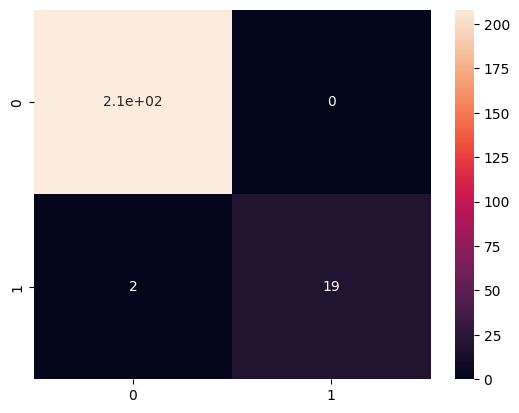

In [14]:
#run the code
import os
import time
import torch
import pickle
import numpy as np
import torch.nn.functional as F
from shutil import copyfile
from tqdm import tqdm
from torch.utils import data
from torch.optim.adadelta import Adadelta
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn import metrics

import copy
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

torch.autograd.set_detect_anomaly(False)
#二分割できる（訓練用とテスト用）

#from pose_utils import motions_map
import sys
sys.path.append("../")
# from Actionsrecognition.Models import *
import pandas as pd
save_folder = 'saved/GSTCAN_UR_conv'

#device = 'cuda'
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("using", device, "device")

epochs = 100
batch_size = 32 #32

# DATA FILES.
# Should be in format of
#  inputs: (N_samples, time_steps, graph_node, channels),
#  labels: (N_samples, num_class)
#   and do some of normalizations on it. Default data create from:
#       Data.create_dataset_(1-3).py
# where
#   time_steps: Number of frame input sequence, Default: 30
#   graph_node: Number of node in skeleton, Default: 14
#   channels: Inputs data (x, y and scores), Default: 3
#   num_class: Number of pose class to train, Default: 7

data_files = ['../Data/ur_fall_sensor_2cl_new-set(labelXscrw).pkl']

class_names = ['Fall','No_fall']
# num_class = len(class_names)


def accuracy_batch(y_pred, y_true):
    return (y_pred.argmax(1) == y_true.argmax(1)).mean()


def set_training(model, mode=True):
    for p in model.parameters():
        p.requires_grad = mode
    model.train(mode)
    return model


if __name__ == '__main__':
    
    #save_folder = os.path.join(os.path.dirname(), save_folder)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    # print('Start')

    # DATA.
    train_loader, valid_loader = load_dataset_v2(data_files[0:1], batch_size,split_size=0.2) 
    
    dataloader = {'train': train_loader, 'valid': valid_loader, }
    
    #print(train_loader.shape)
    
    # MODEL.(list化)
    ## for sensor data
    # model = BiLSTM(input_size=4,hidden_size=64,num_layers=1,dropout_prob=0.3,num_classes=2,feature="mean").to(device)
    # model = CNN_BiLSTM(hidden_size=16,num_layers=1,dropout_prob=0.3,num_classes=2,feature="mean").to(device)
    graph_args = {'strategy': 'spatial'}
    model = TwoStreamSpatialTemporalGraph(graph_args, 2).to(device)
    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"number of params: {n_parameters}")
    # graph_args = {'strategy': 'uniform'}
    #graph_args = {'strategy': 'distance'}
    # print("err")
   
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    
    
    # losser = torch.nn.BCELoss() #fall or no_fall
    losser = torch.nn.CrossEntropyLoss()

    # TRAINING.
    loss_list = {'train': [], 'valid': []}
    accu_list = {'train': [], 'valid': []}
    best_acc = -1
    for e in range(epochs):
        print('Epoch {}/{}'.format(e, epochs - 1))
        for phase in ['train', 'valid']:
            if phase == 'train':
                model = set_training(model, True)
            else:
                model = set_training(model, False)

            run_loss = 0.0
            run_accu = 0.0
            with tqdm(dataloader[phase], desc=phase) as iterator:
                for info in iterator:
                    # print(len(info))
                    pts, ser, lbs = info
                    # print(torch.any(torch.isnan(pts)))
                    # Create motion input by distance of points (x, y) of the same node
                    # in two frames.
                    #print("err")
                    mot = pts[:, :2, 1:, :] - pts[:, :2, :-1, :]
                    
                    mot = mot.to(device)
                    pts = pts.to(device)
                    ser = ser.to(device)
                    print#(ser.size())
                    lbs = lbs.to(device)
                    
                    #print(pts.size())torch.Size([32, 3, 30, 14])
                    #print(mot.size())torch.Size([32, 2, 29, 14])
                    
                    # Forward.
                    # out = model((pts, mot))#タプル型
                    # out = model(ser) # for sensor data
                    
                    out = model((pts, mot, ser))
                    
                    #out = model(mot)#タプル型
                    # print(lbs)

                    # print(out)
                    loss = losser(out, lbs)
                    #print("err")
                    if phase == 'train':
                        # Backward.
                        model.zero_grad()
                        loss.backward()
                        optimizer.step()

                    run_loss += loss.item()
                    accu = accuracy_batch(out.detach().cpu().numpy(),
                                          lbs.detach().cpu().numpy())
                    run_accu += accu

                    iterator.set_postfix_str(' loss: {:.4f}, accu: {:.4f}'.format(
                        loss.item(), accu))
                    iterator.update()
                    #break
            loss_list[phase].append(run_loss / len(iterator))
            accu_list[phase].append(run_accu / len(iterator))
            #print(accu_list)
            #print(torch.max(accu_list))
        if(best_acc < accu_list['valid'][-1]):
            best_acc = accu_list['valid'][-1]
            best_model = copy.deepcopy(model)
            torch.save(model.state_dict(), os.path.join(save_folder, 'tsstg-model_best.pth'))
            #break

        print('Summary epoch:\n - Train loss: {:.4f}, accu: {:.4f}\n - Valid loss:'
        ' {:.4f}, accu: {:.4f}'.format(loss_list['train'][-1], accu_list['train'][-1],
        loss_list['valid'][-1], accu_list['valid'][-1]))
        print(best_acc)
        plt.figure()
        plt.plot(list(range(len(loss_list['train']))),loss_list['train'],label="train_loss")
        plt.plot(list(range(len(loss_list['valid']))),loss_list['valid'],label="valid_loss")
        plt.legend()
        plt.savefig(os.path.join(save_folder, f'musa-model_of_loss_report_ur.png'))
        plt.clf()
        plt.close()
        
        plt.figure()
        plt.plot(list(range(len(accu_list['train']))),accu_list['train'],label="train_acc")
        plt.plot(list(range(len(accu_list['valid']))),accu_list['valid'],label="valid_acc")
        plt.legend()
        plt.savefig(os.path.join(save_folder, f'musa-model_of_acc_report.png'))
        plt.clf()
        plt.close()
        df = pd.DataFrame([loss_list['train'],loss_list['valid']]) 
        df.to_csv(os.path.join(save_folder, f'musa-model_of_acc_report.csv'))
                  
        df = pd.DataFrame([accu_list['train'],accu_list['valid']])
        df.to_csv(os.path.join(save_folder, f'musa-model_of_accu_report.csv'))
        torch.save(best_model.state_dict(), os.path.join(save_folder, f'musa-model_of_{best_acc:.4f}_UR.pth'))

        # SAVE.
        '''
        if(best_acc < accu_list['valid'][-1]):
            best_acc = accu_list['valid'][-1]
            torch.save(model.state_dict(), os.path.join(save_folder, 'tsstg-model_best.pth'))
            '''
        '''
        plot_graphs(list(loss_list.values()), list(loss_list.keys()),
                        'Last Train: {:.2f}, Valid: {:.2f}'.format(
                            loss_list['train'][-1], loss_list['valid'][-1]
                        ), 'Loss', xlim=[0, epochs],
                        save=os.path.join(save_folder, 'loss_graph.png'))
        plot_graphs(list(accu_list.values()), list(accu_list.keys()),
                        'Last Train: {:.2f}, Valid: {:.2f}'.format(
                            accu_list['train'][-1], accu_list['valid'][-1]
                        ), 'Accu', xlim=[0, epochs],
                        save=os.path.join(save_folder, 'accu_graph.png'))
        '''
            #break

    del train_loader, valid_loader

    #model.load_state_dict(torch.load(os.path.join(save_folder, 'tsstg-model.pth',map_location=torch.device('cpu'))))
    model.load_state_dict(torch.load(os.path.join(save_folder, 'tsstg-model_best.pth')))
    # EVALUATION.
    #URのときは全部コメント
    # model = set_training(model, False)
    # data_file = data_files[1]
    # eval_loader, _ = load_dataset([data_file], 32)
    
    print('Evaluation.')
    run_loss = 0.0
    run_accu = 0.0
    y_preds = []
    y_trues = []
    model = best_model
    #with tqdm(eval_loader, desc='eval') as iterator:
    #URFD
    with tqdm(dataloader[phase], desc='eval') as iterator:
        for pts,ser, lbs in iterator:
            # print(lbs)
            mot = pts[:, :2, 1:, :] - pts[:, :2, :-1, :]
            mot = mot.to(device)
            pts = pts.to(device)
            ser = ser.to(device)
            lbs = lbs.to(device)

            # out = model((pts, mot)) # for skeleton data
            # out = model(ser) # for sensor data
            out = model((pts, mot, ser))
            #out = model(mot)################
            loss = losser(out, lbs)

            run_loss += loss.item()
            accu = accuracy_batch(out.detach().cpu().numpy(),
                                  lbs.detach().cpu().numpy())
            run_accu += accu

            y_preds.extend(out.argmax(1).detach().cpu().numpy())
            y_trues.extend(lbs.argmax(1).cpu().numpy())

            iterator.set_postfix_str('loss: {:.4f}, accu: {:.4f}'.format(
                loss.item(), accu))
            iterator.update()

    run_loss = run_loss / len(iterator)
    run_accu = run_accu / len(iterator)
    print('Eval Loss {:.4f}, Accu: {:.4f}'.format(run_loss, run_accu))
    print('Precision:', precision_score(y_trues, y_preds,average='micro'))
    print('Recall:', recall_score(y_trues, y_preds,average='micro'))
    print('F1-score:', f1_score(y_trues, y_preds,average='micro'))
    tn, fp, fn, tp = metrics.confusion_matrix(y_trues, y_preds).ravel()
    specificity  = tn / (tn + fp)
    print('Specificity:', specificity)
    print(classification_report(y_trues, y_preds,digits=5))
    report=classification_report(y_trues,  y_preds, digits=5,output_dict=True)
    report_df = pd.DataFrame(report).T
    report_df.to_csv(os.path.join(save_folder, f'musa-model_of_{run_accu:.4f}_report.csv'))

    cmx_data = confusion_matrix(y_trues, y_preds)

    df_cmx = pd.DataFrame(cmx_data)

    plt.figure()
    sns.heatmap(df_cmx, annot=True)
    plt.savefig(os.path.join(save_folder, f'musa-model_ofs_confution_matrix.png'))


In [ ]:
print(phase)Classification_Module

In [ ]:

train_loader, _ = load_dataset(data_files[0:1], batch_size) #batch_size = 32

valid_loader, train_loader_ = load_dataset(data_files[:1], batch_size, 0.2)
#print("err")
train_loader = data.DataLoader(data.ConcatDataset([train_loader.dataset, train_loader_.dataset]),
                               batch_size, shuffle=True)
dataloader = {'train': train_loader, 'valid': valid_loader}

In [ ]:
 with tqdm(dataloader[phase], desc='eval') as iterator:
        for pts, lbs in iterator:
            mot = pts[:, :2, 1:, :] - pts[:, :2, :-1, :]
            print(mot.shape)
            print(lbs)
            break


In [ ]:
import os.path

print("__file__:{}".format(os.path.dirname(__file__)))
print("dirname :{}".format(os.path.dirname(__file__)))
print("basename:{}".format(os.path.basename(__file__)))
print("files   :{}".format(os.listdir(os.path.dirname(__file__))))